# Image Caption Generator using CNN and LSTM  on Flickr8K dataset  

## Import the required libraries

In [1]:
import numpy as np 
import pandas as pd 
import os 
import tensorflow as tf 
from keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Model 
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation 
from keras.layers import concatenate, BatchNormalization, Input
from keras.layers import add
from keras.utils import to_categorical, plot_model 
from keras.applications.inception_v3 import InceptionV3, preprocess_input 
import matplotlib.pyplot as plt # for plotting data 
import cv2 

## Load the descriptions

In [2]:
token_path = 'C:/Users/megha/Downloads/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
text = open(token_path, 'r', encoding = 'utf-8').read() 
print(text[:500])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7


In [3]:
def load_description(text): 
    mapping = dict() 
    for line in text.split("\n"): 
        token = line.split("\t") 
        if len(line) < 2: # remove short descriptions 
            continue
        img_id = token[0].split('.')[0] # name of the image 
        img_des = token[1] # description of the image 
        if img_id not in mapping: 
            mapping[img_id] = list() 
        mapping[img_id].append(img_des) 
    return mapping 

descriptions = load_description(text) 
print("Number of items: " + str(len(descriptions)))


Number of items: 8092


In [4]:
descriptions['1000268201_693b08cb0e']


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

## Cleaning the text

In [5]:
import string
def clean_description(desc): 
    for key, des_list in desc.items(): 
        for i in range(len(des_list)): 
            caption = des_list[i] 
            caption = [ch for ch in caption if ch not in string.punctuation] 
            caption = ''.join(caption) 
            caption = caption.split(' ') 
            caption = [word.lower() for word in caption if len(word)>1 and word.isalpha()] 
            caption = ' '.join(caption) 
            des_list[i] = caption 
clean_description(descriptions) 
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

## Generate the Vocabulary

In [6]:
def to_vocab(desc): 
    words = set() 
    for key in desc.keys(): 
        for line in desc[key]: 
            words.update(line.split()) 
    return words 
vocab = to_vocab(descriptions)
len(vocab)

8763

## Load the images

In [7]:
import glob 
images = 'C:/Users/megha/Downloads/Flickr_Data/Images/'
# Create a list of all image names in the directory 
img = glob.glob(images + '*.jpg')
len(img)

8091

In [8]:
train_path = 'C:/Users/megha/Downloads/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
train_images = open(train_path, 'r', encoding = 'utf-8').read().split("\n") 
train_img = []  # list of all images in training set 
for im in img: 
    if(im[len(images):] in train_images): 
        train_img.append(im) 

In [9]:
test_path = 'C:/Users/megha/Downloads/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
test_images = open(test_path, 'r', encoding = 'utf-8').read().split("\n")
test_img = []
for im in img:
    if(im[len(images): ] in test_images):
        test_img.append(im)
len(test_img)

1000

In [10]:
# load descriptions of training set in a dictionary. Name of the image will act as ey 
def load_clean_descriptions(des, dataset): 
    dataset_des = dict() 
    for key, des_list in des.items(): 
        if key+'.jpg' in dataset: 
            if key not in dataset_des: 
                dataset_des[key] = list() 
            for line in des_list: 
                desc = 'startseq ' + line + ' endseq'
                dataset_des[key].append(desc) 
    return dataset_des 
  
train_descriptions = load_clean_descriptions(descriptions, train_images) 
print('Descriptions: train=%d' % len(train_descriptions))


Descriptions: train=6000


In [11]:
train_descriptions['1000268201_693b08cb0e']


['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Extract the feature vector from all images

In [12]:
from keras.preprocessing.image import load_img, img_to_array 
def preprocess_img(img_path): 
    # inception v3 excepts img in 299 * 299 * 3 
    img = load_img(img_path, target_size = (299, 299)) 
    x = img_to_array(img) 
    # Add one more dimension 
    x = np.expand_dims(x, axis = 0) 
    x = preprocess_input(x) 
    return x 

In [13]:
base_model = InceptionV3(weights = 'imagenet') 
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 299, 299, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 149, 149, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 149, 149, 32)      │              96 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 149, 149, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 147, 147, 32)      │           9,216 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 147, 147, 32)      │              96 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 147, 147, 32)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 147, 147, 64)      │          18,432 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 147, 147, 64)      │             192 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 147, 147, 64)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 73, 73, 64)        │               0 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 73, 73, 80)        │           5,120 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 73, 73, 80)        │             240 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 73, 73, 80)        │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 71, 71, 192)       │         138,240 │ activation_3[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,851,784 (90.99 MB)

 Trainable params: 23,817,352 (90.86 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [14]:
model = Model(base_model.input, base_model.layers[-2].output) 

In [15]:
def encode(image): 
    image = preprocess_img(image) 
    vec = model.predict(image) 
    vec = np.reshape(vec, (vec.shape[1])) 
    return vec 

In [16]:
# run the encode function on all train images and store the feature vectors in a list 
import time
start = time.time()
encoding_train = {} 
for img in train_img: 
    encoding_train[img[len(images):]] = encode(img) 
print("Time Taken is: " + str(time.time() - start))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━

In [17]:
#Encode all the test images
start = time.time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken is: " + str(time.time() - start))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━

In [18]:
train_features = encoding_train
test_features = encoding_test
print("Train image encodings: " + str(len(train_features)))
print("Test image encodings: " + str(len(test_features)))

Train image encodings: 6000
Test image encodings: 1000


In [19]:
train_features['1000268201_693b08cb0e.jpg'].shape

(2048,)

In [20]:
#list of all training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for caption in val:
        all_train_captions.append(caption)
len(all_train_captions)

30000

##  Tokenizing the vocabulary

In [21]:
vocabulary = vocab 
threshold = 10 # you can change this value according to your need 
word_counts = {} 
for cap in all_train_captions: 
    for word in cap.split(' '): 
        word_counts[word] = word_counts.get(word, 0) + 1
vocab = [word for word in word_counts if word_counts[word] >= threshold] 
print("Unique words: " + str(len(word_counts)))
print("our Vocabulary: " + str(len(vocab)))

Unique words: 7578
our Vocabulary: 1651


In [22]:
#word mapping to integers
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocab:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1

In [23]:
vocab_size = len(ixtoword) + 1  #1 for appended zeros
vocab_size

1652

In [24]:
#find the maximum length of a description in a dataset
max_length = max(len(des.split()) for des in all_train_captions)
max_length

34

## Glove vector embeddings

In [25]:
X1, X2, y = list(), list(), list()
for key, des_list in train_descriptions.items():
    pic = train_features[key + '.jpg']
    for cap in des_list:
        seq = [wordtoix[word] for word in cap.split(' ') if word in wordtoix]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            #store
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)
print(X1.shape)


(292328, 2048)


In [26]:
# load glove vectors for embedding layer 
embeddings_index = {} 
golve_path ='C:/Users/megha/Downloads/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
glove = open(golve_path, 'r', encoding = 'utf-8').read() 
for line in glove.split("\n"): 
    values = line.split(" ") 
    word = values[0] 
    indices = np.asarray(values[1: ], dtype = 'float32') 
    embeddings_index[word] = indices 
print('Total word vectors: ' + str(len(embeddings_index)))

Total word vectors: 400001


In [27]:
emb_dim = 200
emb_matrix = np.zeros((vocab_size, emb_dim)) 
for word, i in wordtoix.items(): 
    if i < vocab_size:
        emb_vec = embeddings_index.get(word) 
        if emb_vec is not None: 
            emb_matrix[i] = emb_vec
emb_matrix.shape

(1652, 200)

## Define the model

In [28]:
# define the model 
ip1 = Input(shape = (2048, )) 
fe1 = Dropout(0.2)(ip1) 
fe2 = Dense(256, activation = 'relu')(fe1) 
ip2 = Input(shape = (max_length, )) 
se1 = Embedding(vocab_size, emb_dim, mask_zero = True)(ip2) 
se2 = Dropout(0.2)(se1) 
se3 = LSTM(256)(se2) 
decoder1 = add([fe2, se3]) 
decoder2 = Dense(256, activation = 'relu')(decoder1) 
outputs = Dense(vocab_size, activation = 'softmax')(decoder2) 
model = Model(inputs = [ip1, ip2], outputs = outputs)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 34)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 2048)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 34, 200)           │         330,400 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 2048)              │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 34, 200)           │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 34)                │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 256)               │         524,544 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 256)               │         467,968 │ dropout_1[0][0],           │
│                               │                           │                 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 256)               │               0 │ dense[0][0], lstm[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 256)               │          65,792 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1652)              │         424,564 │ dense_1[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 1,813,268 (6.92 MB)

 Trainable params: 1,813,268 (6.92 MB)

 Non-trainable params: 0 (0.00 B)

## Training the model

In [29]:
model.layers[2]

<Embedding name=embedding, built=True>

In [33]:
model.layers[2].set_weights([emb_matrix]) 
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam') 

In [35]:
for i in range(10):
    model.fit([X1, X2], y, epochs=1, batch_size=256)
    if i % 2 == 0:
        model.save_weights("image-caption-weights" + str(i) + ".weights.h5")


1142/1142 ━━━━━━━━━━━━━━━━━━━━ 227s 198ms/step - loss: 3.2053
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 225s 197ms/step - loss: 2.9258
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 227s 198ms/step - loss: 2.7567
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 237s 207ms/step - loss: 2.6311
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 226s 198ms/step - loss: 2.5252
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 239s 209ms/step - loss: 2.4488
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 222s 194ms/step - loss: 2.3752
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 1202s 1s/step - loss: 2.3126
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 238s 209ms/step - loss: 2.2605
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 226s 198ms/step - loss: 2.2041


##  Predicting the output

In [36]:
def greedy_search(pic):
    start = 'startseq'
    for i in range(max_length):
        seq = [wordtoix[word] for word in start.split() if word in wordtoix]
        seq = pad_sequences([seq], maxlen = max_length)
        yhat = model.predict([pic, seq])
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        start += ' ' + word
        if word == 'endseq':
            break
    final = start.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

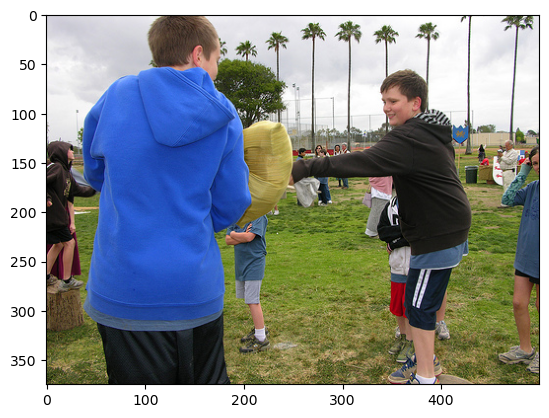

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
man in blue shirt and blue jeans walks down the street


In [37]:
pic = list(encoding_test.keys())[250]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

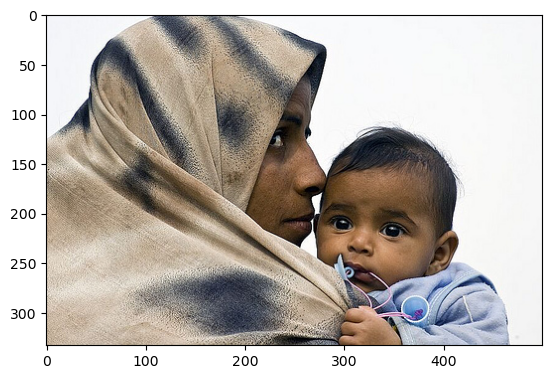

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
baby is licking his face covered in


In [38]:
pic = list(encoding_test.keys())[570]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

In [39]:
model.save("my_model.h5")

In [40]:
#train it for some more time
model.fit([X1, X2], y, epochs = 1, batch_size = 64)
model.save("my_model_"+str(i)+".h5")

4568/4568 ━━━━━━━━━━━━━━━━━━━━ 312s 68ms/step - loss: 2.4612


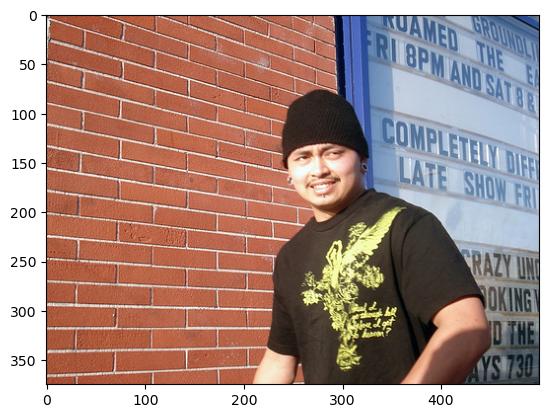

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
man in black and black leather jacket and hat is walking past an alley


In [41]:
pic = list(encoding_test.keys())[888]
img = encoding_test[pic].reshape(1, 2048)
x = plt.imread(images + pic)
plt.imshow(x)
plt.show()
print(greedy_search(img))

In [42]:
model.save("my-image.h5")